Начальный размер train: (1168, 81), test: (292, 80)
Размер объединенных данных: (1460, 79)

Числовых признаков: 36
Категориальных признаков: 43

Пропусков в данных не осталось.

Создание новых признаков...

Трансформация целевой переменной и числовых признаков...
Кандидаты на логарифмирование (асимметрия > 0.5): 31 признаков.
Проверка безопасности применения log1p...
ПРЕДУПРЕЖДЕНИЕ: В признаке 'RemodAge' есть значения == -1. Log1p вернет -inf. Log1p не будет применен.
Логарифмируем 30 асимметричных признаков...

Применение One-Hot Encoding к категориальным признакам...
Количество категориальных признаков для OHE: 43
Размер данных после OHE: (1460, 268). Добавлено 180 признаков.

Размер X_train: (1168, 268)
Размер X_test: (292, 268)
Размер y_train_log: (1168,)

Проверка на константные колонки...
Найдены константные колонки в X_train: ['RoofMatl_Membran']
Удаление константных колонок из X_train и X_test...
Новые размеры: X_train (1168, 267), X_test (292, 267)

Финальная проверка данных п

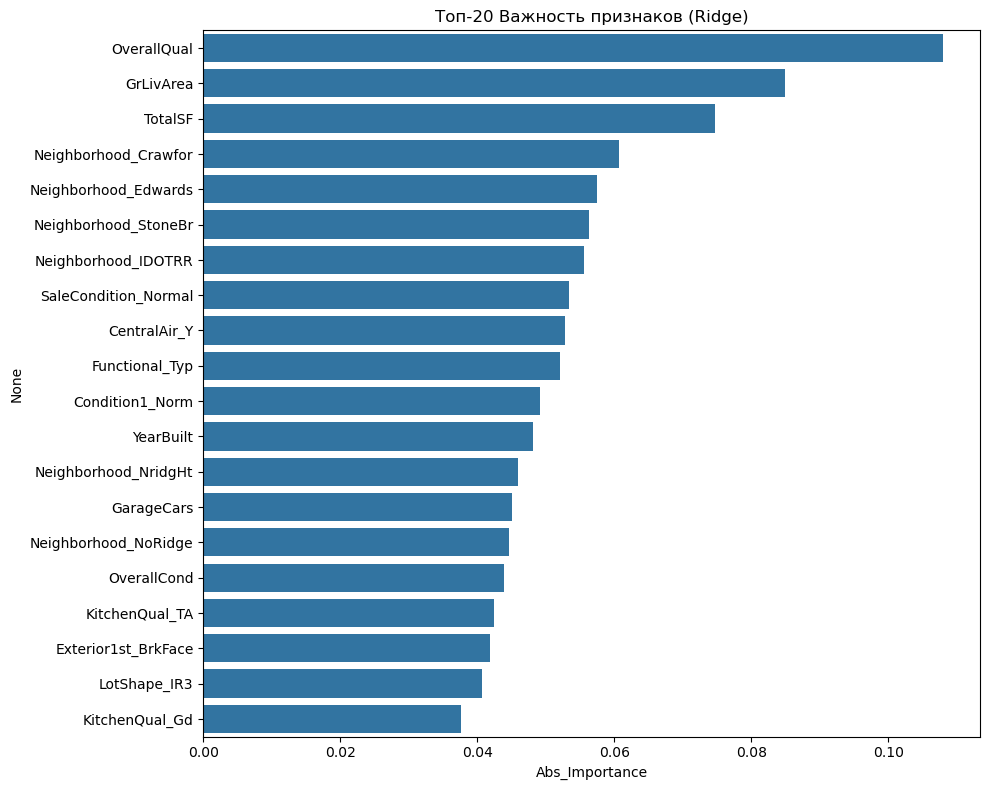

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, cross_val_score
from sklearn.preprocessing import RobustScaler # Оставляем RobustScaler
from sklearn.linear_model import RidgeCV
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_log_error
from sklearn.impute import SimpleImputer # Добавим импьютер на всякий случай
import warnings

warnings.filterwarnings('ignore')

# --- 1. Загрузка данных ---
try:
    train_data = pd.read_csv('train_hw.csv')
    test_data = pd.read_csv('test_hw.csv')
except FileNotFoundError:
    print("Ошибка: Файлы train_hw.csv и/или test_hw.csv не найдены. Убедитесь, что они находятся в той же директории.")
    exit()


print(f"Начальный размер train: {train_data.shape}, test: {test_data.shape}")

# Сохраняем ID для тестового набора и целевую переменную для обучающего
train_id = train_data['Id']
test_id = test_data['Id']
y_train_full = train_data['SalePrice']

# Проверка на нулевые или отрицательные цены (важно для log1p)
if (y_train_full <= 0).any():
    print("ВНИМАНИЕ: В SalePrice есть нулевые или отрицательные значения! Это вызовет проблемы с log1p и MSLE.")
    # Решите, что делать: удалить эти строки, заменить значения или использовать другую трансформацию/метрику
    # Например, удаление:
    # problematic_indices = y_train_full[y_train_full <= 0].index
    # train_data = train_data.drop(problematic_indices)
    # y_train_full = y_train_full.drop(problematic_indices)
    # train_id = train_id.drop(problematic_indices) # Синхронизируем ID
    # print(f"Удалено {len(problematic_indices)} строк с некорректной SalePrice.")


# Удаляем ID и SalePrice из основных данных для препроцессинга
train_data = train_data.drop(['Id', 'SalePrice'], axis=1)
test_data = test_data.drop('Id', axis=1)

# Объединяем для единообразного препроцессинга
all_data = pd.concat((train_data, test_data)).reset_index(drop=True)
print(f"Размер объединенных данных: {all_data.shape}")

# --- 2. Анализ и обработка пропущенных значений ---

# Выделим числовые и категориальные признаки
numerical_features = all_data.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = all_data.select_dtypes(include=['object']).columns.tolist()

print(f"\nЧисловых признаков: {len(numerical_features)}")
print(f"Категориальных признаков: {len(categorical_features)}")

# Пропуски в категориальных признаках
for col in ['Alley', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
            'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond',
            'PoolQC', 'Fence', 'MiscFeature', 'MasVnrType']:
     if col in all_data.columns:
        all_data[col] = all_data[col].fillna('None')

for col in categorical_features:
    if all_data[col].isnull().any():
        mode_val = all_data[col].mode()[0]
        all_data[col] = all_data[col].fillna(mode_val)

# Пропуски в числовых признаках
if 'LotFrontage' in all_data.columns:
    all_data['LotFrontage'] = all_data.groupby('Neighborhood')['LotFrontage'].transform(
        lambda x: x.fillna(x.median()))
else:
     print("Предупреждение: Признак 'LotFrontage' отсутствует.")


if 'GarageYrBlt' in all_data.columns:
     all_data['GarageYrBlt'] = all_data['GarageYrBlt'].fillna(0)
else:
    print("Предупреждение: Признак 'GarageYrBlt' отсутствует.")


if 'MasVnrArea' in all_data.columns:
    all_data['MasVnrArea'] = all_data['MasVnrArea'].fillna(0)
else:
    print("Предупреждение: Признак 'MasVnrArea' отсутствует.")


# Обновляем список числовых признаков после возможных удалений/добавлений
numerical_features = all_data.select_dtypes(include=[np.number]).columns.tolist()

for col in numerical_features:
    if all_data[col].isnull().any():
        median_val = all_data[col].median()
        all_data[col] = all_data[col].fillna(median_val)

nans_left = all_data.isnull().sum().sum()
if nans_left == 0:
    print("\nПропусков в данных не осталось.")
else:
    print(f"\nВНИМАНИЕ: Осталось {nans_left} пропусков.")
    print(all_data.isnull().sum()[all_data.isnull().sum() > 0])


# --- 3. Инженерия признаков ---
print("\nСоздание новых признаков...")
all_data['TotalSF'] = all_data.get('TotalBsmtSF', 0) + all_data.get('1stFlrSF', 0) + all_data.get('2ndFlrSF', 0)
all_data['HouseAge'] = all_data.get('YrSold', all_data['YearBuilt'].max()) - all_data.get('YearBuilt', 0) # Добавил get для надежности
all_data['RemodAge'] = all_data.get('YrSold', all_data['YearRemodAdd'].max()) - all_data.get('YearRemodAdd', 0)
all_data['TotalBath'] = all_data.get('FullBath', 0) + 0.5 * all_data.get('HalfBath', 0) + \
                       all_data.get('BsmtFullBath', 0) + 0.5 * all_data.get('BsmtHalfBath', 0)
all_data['HasPool'] = all_data.get('PoolArea', 0).apply(lambda x: 1 if x > 0 else 0)
all_data['Has2ndFlr'] = all_data.get('2ndFlrSF', 0).apply(lambda x: 1 if x > 0 else 0)
all_data['HasGarage'] = all_data.get('GarageArea', 0).apply(lambda x: 1 if x > 0 else 0)
all_data['HasBsmt'] = all_data.get('TotalBsmtSF', 0).apply(lambda x: 1 if x > 0 else 0)
all_data['HasFireplace'] = all_data.get('Fireplaces', 0).apply(lambda x: 1 if x > 0 else 0)

# --- 4. Трансформация признаков ---
print("\nТрансформация целевой переменной и числовых признаков...")
# Логарифмируем целевую переменную
y_train_log = np.log1p(y_train_full)

# Обновляем список числовых признаков после инженерии
numerical_features = all_data.select_dtypes(include=[np.number]).columns.tolist()

# Исключим бинарные/псевдо-категориальные из поиска асимметрии
exclude_from_skew_check = ['Id', 'MSSubClass'] + [col for col in all_data.columns if 'Has' in col] # Добавили 'Has*' признаки
numerical_for_skew = [f for f in numerical_features if f not in exclude_from_skew_check and all_data[f].nunique() > 2]

if numerical_for_skew: # Проверка, что список не пуст
    skewness = all_data[numerical_for_skew].apply(lambda x: x.skew()).sort_values(ascending=False)
    high_skew = skewness[abs(skewness) > 0.5]
    skewed_features = high_skew.index
    print(f"Кандидаты на логарифмирование (асимметрия > 0.5): {len(skewed_features)} признаков.")

    features_to_log = []
    print("Проверка безопасности применения log1p...")
    for feat in skewed_features:
        if (all_data[feat] < -1).any(): # Проверяем на значения < -1, т.к. log1p(-1) = -inf
             print(f"ПРЕДУПРЕЖДЕНИЕ: В признаке '{feat}' есть значения < -1. Log1p не будет применен.")
        elif (all_data[feat] == -1).any():
             print(f"ПРЕДУПРЕЖДЕНИЕ: В признаке '{feat}' есть значения == -1. Log1p вернет -inf. Log1p не будет применен.")
        else:
            features_to_log.append(feat)

    if features_to_log:
        print(f"Логарифмируем {len(features_to_log)} асимметричных признаков...")
        for feat in features_to_log:
             all_data[feat] = np.log1p(all_data[feat])
    else:
        print("Нет подходящих признаков для безопасного логарифмирования.")

else:
    print("Не найдено числовых признаков для проверки асимметрии.")


# --- 5. Обработка категориальных признаков ---
if 'Utilities' in all_data.columns:
    if all_data['Utilities'].nunique() < 2:
        print("Удаление признака 'Utilities' из-за низкой вариативности.")
        all_data = all_data.drop('Utilities', axis=1)

print("\nПрименение One-Hot Encoding к категориальным признакам...")
categorical_features = all_data.select_dtypes(include=['object']).columns.tolist()
print(f"Количество категориальных признаков для OHE: {len(categorical_features)}")

initial_cols = all_data.shape[1]
all_data = pd.get_dummies(all_data, columns=categorical_features, drop_first=True, dummy_na=False)
print(f"Размер данных после OHE: {all_data.shape}. Добавлено {all_data.shape[1] - initial_cols} признаков.")

# --- 6. Подготовка данных для модели ---
# Разделяем обратно на train и test
X_train = all_data[:len(train_id)]
X_test = all_data[len(train_id):]

print(f"\nРазмер X_train: {X_train.shape}")
print(f"Размер X_test: {X_test.shape}")
print(f"Размер y_train_log: {y_train_log.shape}")

# Проверка и удаление константных колонок (важно перед RobustScaler)
print("\nПроверка на константные колонки...")
constant_columns_train = X_train.columns[X_train.nunique() == 1].tolist()
if constant_columns_train:
    print(f"Найдены константные колонки в X_train: {constant_columns_train}")
    print("Удаление константных колонок из X_train и X_test...")
    X_train = X_train.drop(columns=constant_columns_train)
    # Убедимся, что удаляем те же колонки из теста, даже если они там не константные
    cols_to_drop_in_test = [col for col in constant_columns_train if col in X_test.columns]
    X_test = X_test.drop(columns=cols_to_drop_in_test)
    print(f"Новые размеры: X_train {X_train.shape}, X_test {X_test.shape}")
else:
    print("Константных колонок в X_train не найдено.")

# Финальная проверка на NaN и Inf перед fit
print("\nФинальная проверка данных перед обучением:")
print(f"NaNs в X_train: {X_train.isnull().sum().sum()}")
print(f"Infinities в X_train: {np.isinf(X_train).values.sum()}") # .values.sum() надежнее для DataFrame
print(f"NaNs в X_test: {X_test.isnull().sum().sum()}")
print(f"Infinities в X_test: {np.isinf(X_test).values.sum()}")

# Если проблемы остались (например, Inf от log1p(-1) проскочили), применяем замену
if np.isinf(X_train).values.any() or X_train.isnull().values.any():
   print("\nОбнаружены NaN или Inf перед fit! Применяем SimpleImputer(strategy='median')...")
   # Заменяем Inf на NaN, чтобы импьютер их обработал
   X_train = X_train.replace([np.inf, -np.inf], np.nan)
   X_test = X_test.replace([np.inf, -np.inf], np.nan)

   imputer = SimpleImputer(strategy='median')
   X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
   X_test = pd.DataFrame(imputer.transform(X_test), columns=X_test.columns, index=X_test.index)
   print(f"Проверка после импутации: Nans={X_train.isnull().sum().sum()}, Inf={np.isinf(X_train).values.sum()}")

# --- 7. Моделирование (Линейная регрессия с регуляризацией) ---
print("\nОбучение модели RidgeCV...")

alphas = np.logspace(-3, 3, 50)

# Используем RobustScaler, так как он устойчив к выбросам, которые могли остаться
ridge_pipeline = make_pipeline(RobustScaler(),
                               RidgeCV(alphas=alphas, store_cv_values=True))

# Обучаем модель
try:
    ridge_pipeline.fit(X_train, y_train_log)
    print("Модель успешно обучена.")
    # Оптимальный alpha
    best_alpha = ridge_pipeline.named_steps['ridgecv'].alpha_
    print(f"Выбранный оптимальный alpha: {best_alpha:.4f}")

    # Оценка на обучающей выборке (MSLE)
    train_pred_log = ridge_pipeline.predict(X_train)
    # Защита от отрицательных предсказаний после обратного преобразования, если вдруг
    train_pred = np.expm1(train_pred_log)
    train_pred[train_pred < 0] = 0 # Ставим минимальную цену 0
    train_msle = mean_squared_log_error(y_train_full, train_pred)
    print(f"MSLE на обучающей выборке: {train_msle:.5f}")
    print(f"RMSLE на обучающей выборке: {np.sqrt(train_msle):.5f}")

except ValueError as e:
    print(f"\nОШИБКА во время обучения модели: {e}")
    print("Возможно, в данных все еще есть проблемы (NaN, Inf, очень большие значения).")
    print("Проверьте максимальные значения в X_train:")
    print(X_train.max().sort_values(ascending=False).head())
    exit() # Прерываем выполнение


# --- 8. Предсказание на тестовой выборке ---
print("\nСоздание предсказаний для тестовой выборки...")
test_pred_log = ridge_pipeline.predict(X_test)
test_pred = np.expm1(test_pred_log)
test_pred[test_pred < 0] = 0 # Убедимся, что нет отрицательных цен

# --- 9. Создание файла для Kaggle ---
submission = pd.DataFrame({
    'Id': test_id,
    'SalePrice': test_pred
})
submission_filename = 'submission_ridge_v2.csv'
submission.to_csv(submission_filename, index=False)
print(f"\nПредсказания сохранены в файл '{submission_filename}'")

# --- Дополнительно: Анализ важности признаков (для Ridge) ---
try:
    ridge_model = ridge_pipeline.named_steps['ridgecv']
    # Получаем имена признаков ПОСЛЕ RobustScaler (если бы использовался ColumnTransformer)
    # Но т.к. Scaler применяется ко всем, имена из X_train подходят
    feature_names = X_train.columns

    importances = pd.DataFrame(ridge_model.coef_, index=feature_names, columns=['Importance'])
    importances['Abs_Importance'] = importances['Importance'].abs()
    importances = importances.sort_values('Abs_Importance', ascending=False)

    print("\nТоп-20 наиболее важных признаков по версии Ridge:")
    print(importances.head(20))

    plt.figure(figsize=(10, 8))
    sns.barplot(x='Abs_Importance', y=importances.head(20).index, data=importances.head(20))
    plt.title('Топ-20 Важность признаков (Ridge)')
    plt.tight_layout()
    plt.savefig('feature_importance_ridge_v2.png')
    print("\nГрафик важности признаков сохранен в 'feature_importance_ridge_v2.png'")

except Exception as e:
    print(f"\nНе удалось построить график важности признаков: {e}")

print("\nСкрипт завершен.")